In [21]:
from torchmil.models import TransMIL
from data_trans import transmil_collate, make_deterministic_dataloader, set_seed
from torchmil.datasets import BinaryClassificationDataset
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
from train_val import train, val
import torch.nn as nn
import numpy as np
import wandb
import torch
import yaml
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [22]:
with open("/home/silvia.collicelli/project/SynDiag_thesis/abmil_approach/milconfig.yaml", "r") as file:
    base_cfg = yaml.safe_load(file)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
features_path = base_cfg["data"]["features_path"]
labels_path = base_cfg["data"]["labels_path"]
k_folds = base_cfg["k_folds"]
seed = base_cfg['seed']

defaults={
    "l_rate": 1e-4,
    "batch_size": 64,
    "numb_frames": 16,
    "epochs": 16,
    "fold": 0, 
    "att_dim": 64,
    "n_layers": 2,
    "n_heads": 8,
    "n_landmarks": None,
    "dropout": 0,
    "use_mlp": False
}

wandb.login()
wandb.init(config=defaults)
config = wandb.config
set_seed(seed)

dataset = BinaryClassificationDataset(features_path+f"{config.numb_frames}", labels_path, bag_keys=["X", "Y"], verbose=False, load_at_init=False)
cv = StratifiedKFold(k_folds, shuffle=True)
bag_labels = [dataset[i]["Y"].item() for i in range(len(dataset))]

train_data = []
val_data = []

for _, (train_idx, val_idx) in enumerate(cv.split(np.zeros(len(bag_labels)), bag_labels)):
    train_data.append(Subset(dataset, train_idx))
    val_data.append(Subset(dataset, val_idx))

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


In [23]:
def tune_thr(probs, targets, thresholds):
    thrs = [i/thresholds for i in range(thresholds)]
    f1s = []
    for thr in thrs:
        preds = []
        for i in range(len(probs)):
            preds.append(float(probs[i][1] > thr))
        f1s.append(f1_score(targets, preds))
        
    return thrs, f1s

In [24]:
thresholds = 100
all_probs = []
all_targets = []
f1s_folds = []
for k in range(k_folds):
    probs = []
    targets = []
    train_dataloader = make_deterministic_dataloader(
        dataset=train_data[k],
        batch_size=config.batch_size,
        num_workers=0,
        pin_memory=False,
        shuffle=True,
        offset=0,
        base_seed=seed,
        sampler=None,
        collate_fn=transmil_collate,
    )
    val_dataloader = make_deterministic_dataloader(
        dataset=val_data[k],
        batch_size=config.batch_size,
        num_workers=0,
        pin_memory=False,
        shuffle=False,
        offset=0,
        base_seed=seed,
        sampler=None,
        collate_fn=transmil_collate,
    )
    in_shape = (dataset[0]["X"].shape[-1],)
    criterion = nn.BCEWithLogitsLoss()
    model = TransMIL(
        in_shape=in_shape, 
        att_dim=config.att_dim, 
        n_layers=config.n_layers,
        n_heads=config.n_heads,
        n_landmarks=config.n_landmarks,
        dropout=config.dropout,
        use_mlp=config.use_mlp
        ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), config.l_rate)
    for epoch in range(config.epochs):      
        train_loss, train_acc = train(model, device, criterion, optimizer, train_dataloader)
        val_loss, val_acc, prob, target = val(model, device, criterion, val_dataloader, epoch, additional_metrics=False)
        #print(f"\tEpoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")            
        if epoch == (config.epochs-1):
            print(epoch)
            probs.append(prob)
            targets.append(target)
            all_probs.append(prob)
            all_targets.append(target)
    targets = [pair for batch in targets for pair in batch]
    probs = [pair for batch in probs for pair in batch]
    thrs, f1s_fold = tune_thr(probs, targets, thresholds)
    f1s_folds.append(f1s_fold)

all_targets = [pair for batch in all_targets for pair in batch]
all_probs = [pair for batch in all_probs for pair in batch]
thrs, f1s = tune_thr(all_probs, all_targets, thresholds)


15
15
15
15
15


In [25]:
mean_f1 = np.mean(f1s_folds, 0)
max_mean = max(mean_f1)
max_mean
best_thr_mean= thrs[np.argmax(mean_f1)]
max_f1 = max(f1s)
best_thr_f1 = thrs[np.argmax(f1s)]

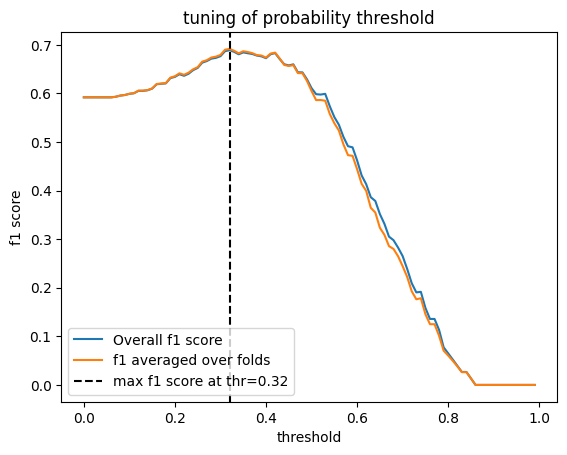

max f1 score: 0.6889460154241646
at decision threshold: 0.32


In [26]:
plt.plot(thrs, f1s, label='Overall f1 score')
plt.plot(thrs, mean_f1, label='f1 averaged over folds')
plt.axvline(best_thr_f1, label=f'max f1 score at thr={best_thr_f1}',color='k', linestyle='--')
plt.legend()
plt.ylabel('f1 score')
plt.xlabel('threshold')
plt.title('tuning of probability threshold')
plt.show()
print(f"max f1 score: {max_f1}\nat decision threshold: {best_thr_f1}")